In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

2024-12-09 14:14:16.314069: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 14:14:16.789470: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class ArtClassifier(keras.Model):
    """Wrapper for 3 different models."""
    
    test = 'Hello'
    culture_model = None
    medium_model = None
    time_model = None
    
    culture_labels = ['Egyptian', 'Greek', 'Roman']
    medium_labels = ['Painting', 'Sculpture', 'Architecture']
    time_labels = ['early', 'middle', 'late']
    
    def __init__(self, culture_model = 'culture_model.keras', medium_model = 'medium_model.keras', 
                  time_model = 'time_model.keras', directory = 'submodels_final'):
        super().__init__()
        self.culture_model = keras.models.load_model(f'{directory}/{culture_model}')
        self.medium_model = keras.models.load_model(f'{directory}/{medium_model}')
        self.time_model = keras.models.load_model(f'{directory}/{time_model}')

        
    def call(self, inputs, training = False):
        # reshape input if not in batch
        if len(inputs.shape) < 4:
            inputs = inputs[np.newaxis]
            
        culture1 = self.culture_model(inputs)
        medium1 = self.medium_model(inputs)
        time1 = self.time_model(inputs)
        
        #print(culture1, medium1, time1) to check if they're all the same, indicating an error
            
        culture_output_i = np.argmax(culture1, axis = 1)
        medium_output_i = np.argmax(medium1, axis = 1)
        time_output_i = np.argmax(time1, axis = 1)
        
        culture_output = [self.culture_labels[i] for i in culture_output_i]
        medium_output = [self.medium_labels[i] for i in medium_output_i]
        time_output = [self.time_labels[i] for i in time_output_i]
        
        return [(c, m, t) for c, m, t in zip(culture_output, medium_output, time_output)]
    
model = ArtClassifier()

2024-12-09 14:14:20.647053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 41643 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:63:00.0, compute capability: 8.6


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7178901471374606379
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 7178901471374606379


tf.Tensor([b'Egyptian' b'Architecture' b'late'], shape=(3,), dtype=string)


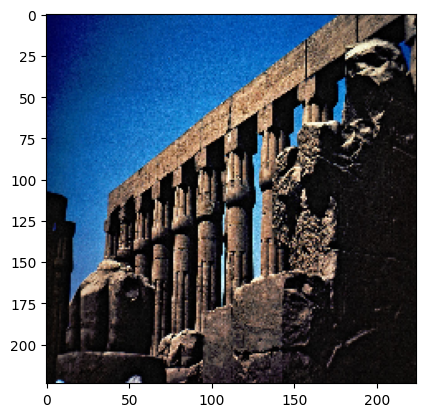

In [41]:
category = 'all'
val_data = tf.data.Dataset.load(f'data/valid_{category}')

inputs = []
inputs2 = []
labels = []
i = 0
for image, label in val_data:
    image = tf.image.resize(image, (224, 224))
    if not image.shape[2] == 3:
        inputs2.append(image)
    else:
        inputs.append(image.numpy())
        labels.append(label.numpy())
    if i == 0:
        print(label)
        i += 1
        plt.imshow(image.numpy())

In [5]:
outputs = model(tf.constant(inputs))
#outputs2 = model(tf.constant(inputs2)) didn't end up getting the model to work with 1-channel images

2024-12-09 14:15:32.401240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-12-09 14:15:33.329573: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix
outputs_df = pd.DataFrame(outputs, columns = ['culture', 'medium', 'time'])
labels_df = pd.DataFrame(labels, columns = ['culture', 'medium', 'time'])
mp = {b'Egyptian' : 'Egyptian'}
for x, y in zip([b'Greek', b'Egyptian', b'Roman', 
                 b'Sculpture', b'Architecture', b'Painting',
                 b'early', b'middle', b'late'],
                ['Greek', 'Egyptian', 'Roman', 
                 'Sculpture', 'Architecture', 'Painting',
                 'early', 'middle', 'late']):
    labels_df = labels_df.replace(x, y)
print(outputs_df.shape[0], 'total predictions')
display(pd.crosstab(pd.Series(labels_df['culture'], name = 'Actual'), pd.Series(outputs_df['culture'], name = 'Predicted')))
display(pd.crosstab(pd.Series(labels_df['medium'], name = 'Actual'), pd.Series(outputs_df['medium'], name = 'Predicted')))
display(pd.crosstab(pd.Series(labels_df['time'], name = 'Actual'), pd.Series(outputs_df['time'], name = 'Predicted')))

329 total predictions


Predicted  Egyptian  Greek  Roman
Actual                           
Egyptian        114      6      0
Greek            67     37      0
Roman            83     21      1

Predicted     Architecture  Painting  Sculpture
Actual                                         
Architecture            11        69          2
Painting                 7       118          1
Sculpture                4        91         26

Predicted  early  late  middle
Actual                        
early         21    17      31
late          20    26      27
middle        15    26     146

In [43]:
outputs_df

culture        medium    time
0    Egyptian      Painting    late
1    Egyptian      Painting  middle
2    Egyptian      Painting   early
3       Greek      Painting  middle
4       Greek      Painting  middle
..        ...           ...     ...
324  Egyptian      Painting   early
325  Egyptian      Painting    late
326  Egyptian      Painting    late
327  Egyptian  Architecture    late
328  Egyptian      Painting  middle

[329 rows x 3 columns]

In [39]:
all_correct = 0
for i in range(outputs_df.shape[0]):
    if outputs_df.culture[i] == labels_df.culture[i] and outputs_df.medium[i] == labels_df.medium[i] and outputs_df.time[i] == labels_df.time[i]:
        all_correct += 1
all_correct / outputs_df.shape[0]

0.11246200607902736

In [5]:
import pandas as pd
metadata = pd.read_csv('data/image_metadata2.csv')
print(metadata.culture.value_counts())
print(metadata.medium.value_counts())
print(metadata.time_period.value_counts())

Greek       2516
Egyptian    1462
Roman       1328
Name: culture, dtype: int64
Sculpture       2347
Painting        1930
Architecture    1029
Name: medium, dtype: int64
middle    3028
early     1180
late      1098
Name: time_period, dtype: int64
